In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
import os
import matplotlib.pyplot as plt
import collections
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
import gc
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm.notebook import tqdm
import lightgbm as lgb
import shap
import math
from sklearn.metrics import mean_squared_error

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.options.mode.chained_assignment = None
path = '../input/bike-sharing-demand/'

/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/test.csv


In [2]:
def sd(col, max_loss_limit=0.001, avg_loss_limit=0.001, na_loss_limit=0, n_uniq_loss_limit=0, fillna=0):
    """
    max_loss_limit - don't allow any float to lose precision more than this value. Any values are ok for GBT algorithms as long as you don't unique values.
                     See https://en.wikipedia.org/wiki/Half-precision_floating-point_format#Precision_limitations_on_decimal_values_in_[0,_1]
    avg_loss_limit - same but calculates avg throughout the series.
    na_loss_limit - not really useful.
    n_uniq_loss_limit - very important parameter. If you have a float field with very high cardinality you can set this value to something like n_records * 0.01 in order to allow some field relaxing.
    """
    is_float = str(col.dtypes)[:5] == 'float'
    na_count = col.isna().sum()
    n_uniq = col.nunique(dropna=False)
    try_types = ['float16', 'float32']

    if na_count <= na_loss_limit:
        try_types = ['int8', 'int16', 'float16', 'int32', 'float32']

    for type in try_types:
        col_tmp = col

        # float to int conversion => try to round to minimize casting error
        if is_float and (str(type)[:3] == 'int'):
            col_tmp = col_tmp.copy().fillna(fillna).round()

        col_tmp = col_tmp.astype(type)
        max_loss = (col_tmp - col).abs().max()
        avg_loss = (col_tmp - col).abs().mean()
        na_loss = np.abs(na_count - col_tmp.isna().sum())
        n_uniq_loss = np.abs(n_uniq - col_tmp.nunique(dropna=False))

        if max_loss <= max_loss_limit and avg_loss <= avg_loss_limit and na_loss <= na_loss_limit and n_uniq_loss <= n_uniq_loss_limit:
            return col_tmp

    # field can't be converted
    return col

def reduce_mem_usage_sd(df, deep=True, verbose=False, obj_to_cat=False):
    numerics = ['int16', 'uint16', 'int32', 'uint32', 'int64', 'uint64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    for col in tqdm(df.columns):
        col_type = df[col].dtypes

        # collect stats
        na_count = df[col].isna().sum()
        n_uniq = df[col].nunique(dropna=False)
        
        # numerics
        if col_type in numerics:
            df[col] = sd(df[col])

        # strings
        if (col_type == 'object') and obj_to_cat:
            df[col] = df[col].astype('category')
        
        if verbose:
            print(f'Column {col}: {col_type} -> {df[col].dtypes}, na_count={na_count}, n_uniq={n_uniq}')
        new_na_count = df[col].isna().sum()
        if (na_count != new_na_count):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost na values. Before: {na_count}, after: {new_na_count}')
        new_n_uniq = df[col].nunique(dropna=False)
        if (n_uniq != new_n_uniq):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost unique values. Before: {n_uniq}, after: {new_n_uniq}')

    end_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df


In [3]:
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))


In [4]:
if not True:
    print('a')

In [5]:
def feature_engineer_pipeline(data, gold):
    data['datetime'] = pd.to_datetime(data['datetime'])

    data["year"] = data['datetime'].dt.year
    data["weekday"] = data['datetime'].dt.weekday
    data["hour"] = data['datetime'].dt.hour
    
    if not gold:
        
        data["month"] = data['datetime'].dt.month
        
#         data['interaction_atemp_humidity'] = data['atemp'] * data['humidity']
#         data['interaction_atemp_wind'] = data['atemp'] - data['windspeed']
#         data['interaction_temp_humidity'] = data['temp'] - data['humidity']
#         data['interaction_temp_wind'] = data['temp'] - data['windspeed']
#         data['interaction_wind_humidity'] = data['windspeed'] - data['humidity']

#         data['diff_temp'] = data['atemp'] - data['temp']
    
    return(data)

def dropper_feature(data, to_drop):
    
    data = data.drop(to_drop, axis = 1)
    
    return data

def lagger_feature(data, column, lag_list):
    
    for col in column:
        for lag in lag_list:
            data[f'lagged{lag}_{col}'] = data[col].shift(lag)
    
    return(data)

def correct_data(data):
    data['weather'].replace({4: 3}, inplace = True)
    
    return data

def aggregation_pipeline(data, numeric_col):
    for col in tqdm(numeric_col):
        
        gc.collect()
        
#         data[f'{col}_agg_month'] = data[['month', col]].groupby(['month']).transform(np.nanmean)
#         data[f'{col}_diff_month'] = data[col] - data[f'{col}_agg_month']
        
        gc.collect()
        data[f'{col}_agg_weekday'] = data[['weekday', col]].groupby(['weekday']).transform(np.nanmean)
        data[f'{col}_diff_weekday'] = data[col] - data[f'{col}_agg_weekday']

        gc.collect()
        data[f'{col}_agg_hour'] = data[['hour', col]].groupby(['hour']).transform(np.nanmean)
        data[f'{col}_diff_hour'] = data[col] - data[f'{col}_agg_hour']
        
    return data


def counter_feature(data, categorical_column):

    for feature in categorical_column:

        x[feature + '_count'] = x[feature].map(data[feature].value_counts(dropna = False, normalize = False))

    return(data)

def hour_part(hour):
    part = np.zeros(hour.shape[0])
    part[hour <= 6] = 0
    part[(hour > 6) & (hour<=12)] = 1
    part[(hour > 12) & (hour<=18)] = 2
    part[(hour > 18) & (hour <= 23)] = 3
    
    return(part)

def loader(path = path, to_log = True, gold = True):
    
    train = pd.read_csv(os.path.join(path, 'train.csv'))
    train['Train'] = True

    test = pd.read_csv(os.path.join(path, 'test.csv'))
    test['Train'] = False
    
    data = pd.concat([train, test], axis = 0)
    
    data = correct_data(data)
    
    data = reduce_mem_usage_sd(data)
    
    data = feature_engineer_pipeline(data, gold)
    data = reduce_mem_usage_sd(data)            
    data = data.sort_values('datetime').reset_index(drop = True)

    to_drop = ['casual', 'registered', 'Train', 'datetime']

    categoric_col = ['season', 'holiday','workingday', 'weather', 'month', 'year', 'weekday', 'hour', 'part', 'day']
    numeric_col = [x for x in data.columns if x not in categoric_col and x not in to_drop + ['count']]
    
#     data = aggregation_pipeline(data, numeric_col)
    
#     to_lag = numeric_col + ['atemp', 'windspeed', 'weather']
    
#     data = lagger_feature(data, to_lag, [1, 2, 3, 4, 5])
    
    categoric_col = list(set(categoric_col + [x for x in data.columns if 'weather' in x]))
    
#     data['part'] = hour_part(data['hour'])
    
    data = reduce_mem_usage_sd(data)
    
    train = data[data['Train']].sort_values('datetime').reset_index(drop = True)
    test = data[~data['Train']].sort_values('datetime').reset_index(drop = True)
    
    train = dropper_feature(train, to_drop) 
    train = train[train.isna().mean(axis = 1) == 0].reset_index(drop = True)
    
    y = train.pop('count')
    
    if to_log:
        y = np.log1p(y)

    test = dropper_feature(test, to_drop + ['count'])

    
    col_strat = ['weekday', 'hour']
    strat = train[col_strat].astype(str).apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    
    le = LabelEncoder()
    strat = le.fit_transform(strat).astype(np.int16)
    
    assert collections.Counter(strat).most_common()[-1][1] >= 8 

    categoric_col = [x for x in categoric_col if x in train.columns]
    numeric_col = [x for x in numeric_col if x in train.columns]

    return train, test, numeric_col, categoric_col, strat, y
    
    
    
def cv_scorer(train, categoric_col):
    n_fold = 5
    folds = KFold(n_splits=n_fold, shuffle = True, random_state = 0)

    score = []

    gc.collect()
    for fold_ , (trn_idx, val_idx) in enumerate(folds.split(train)):

            gc.collect()

            train_x, train_y = train.loc[trn_idx,:], y[trn_idx]
            valid_x, valid_y = train.loc[val_idx,:], y[val_idx]

            model = lgb.train(
                params,
                lgb.Dataset(train_x, label = train_y, categorical_feature = categoric_col),
                100000, valid_sets = lgb.Dataset(valid_x, label = valid_y, categorical_feature = categoric_col),
                categorical_feature = categoric_col,
                valid_names ='validation',
                verbose_eval = 0, early_stopping_rounds = 150
            )

            temp_y = model.predict(valid_x)

            score += [rmse(valid_y, temp_y)]

    return(np.mean(score))

In [6]:
train, test, numeric_col, categoric_col, strat, y = loader(path)


Mem. usage decreased from  2.87 Mb to  1.79 Mb (37.6% reduction)



Mem. usage decreased from  1.06 Mb to  0.73 Mb (31.2% reduction)



Mem. usage decreased from  0.60 Mb to  0.60 Mb (0.0% reduction)


# Importance with shap

In [7]:
seed = 1
params = {
                    'objective': 'regression',
                    'boosting_type': 'gbdt',
                    'metric': 'rmse',
                    'learning_rate': 0.05,
                    'colsample_bytree': 0.7,
                    'max_depth':-1,
                    'num_leaves': 2**8,
                    'lambda_l1': 1,
                    'lambda_l2': 1,
                    'subsample': 0.75,
                    'subsample_freq': 5, 
                    'tree_learner': 'serial',
                    'max_bin': 255,
                    'seed': seed,
                    'n_jobs': -1,
                    'importance_type': 'gain',
}


Startig score with year and none of feature enginereed feature

In [8]:
gold_score = cv_scorer(train, categoric_col)
gold_score

0.2927847384886736

In [9]:
train, test, numeric_col, categoric_col, strat, y = loader(path, gold = False)


Mem. usage decreased from  2.87 Mb to  1.79 Mb (37.6% reduction)



Mem. usage decreased from  1.19 Mb to  0.75 Mb (37.5% reduction)



Mem. usage decreased from  0.61 Mb to  0.61 Mb (0.0% reduction)


In [10]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle = True, random_state = 0)

pred = np.zeros(train.shape[0])
pred_test = np.zeros(test.shape[0])

score = []

model5 =[]

gc.collect()
for fold_ , (trn_idx, val_idx) in tqdm(enumerate(folds.split(train, strat))):
        
        gc.collect()
        
        train_x, train_y = train.loc[trn_idx,:], y[trn_idx]
        valid_x, valid_y = train.loc[val_idx,:], y[val_idx]
        
        model = lgb.train(
            params,
            lgb.Dataset(train_x, label = train_y, categorical_feature = categoric_col),
            100000, valid_sets = lgb.Dataset(valid_x, label = valid_y, categorical_feature = categoric_col),
            categorical_feature = categoric_col,
            valid_names ='validation',
            verbose_eval = 500, early_stopping_rounds = 150
        )
    
        temp_y = model.predict(valid_x)
                
        pred[val_idx] = temp_y
        pred_test += model.predict(test)/n_fold

        score += [rmse(valid_y, temp_y)]
        
        print('\nFold: {}; RMLSE: {:.3f}\n'.format(fold_, rmse(valid_y, temp_y)))
        
        model5.append(model)
        

print('CV - RMSE : {}; STD: {}\n'.format(np.mean(score), np.std(score)))
pred_test = np.expm1(pred_test)

score = np.mean(score)


Training until validation scores don't improve for 150 rounds
[500]	validation's rmse: 0.299313
Early stopping, best iteration is:
[539]	validation's rmse: 0.29879

Fold: 0; RMLSE: 0.299

Training until validation scores don't improve for 150 rounds
[500]	validation's rmse: 0.290028
Early stopping, best iteration is:
[729]	validation's rmse: 0.289331

Fold: 1; RMLSE: 0.289

Training until validation scores don't improve for 150 rounds
[500]	validation's rmse: 0.283597
Early stopping, best iteration is:
[595]	validation's rmse: 0.283343

Fold: 2; RMLSE: 0.283

Training until validation scores don't improve for 150 rounds
[500]	validation's rmse: 0.296299
Early stopping, best iteration is:
[579]	validation's rmse: 0.295791

Fold: 3; RMLSE: 0.296

Training until validation scores don't improve for 150 rounds
[500]	validation's rmse: 0.274429
Early stopping, best iteration is:
[462]	validation's rmse: 0.274086

Fold: 4; RMLSE: 0.274


CV - RMSE : 0.2882683840277255; STD: 0.0088748799510813

Text(0.5, 1.0, '50 TOP feature importance over 5 average')

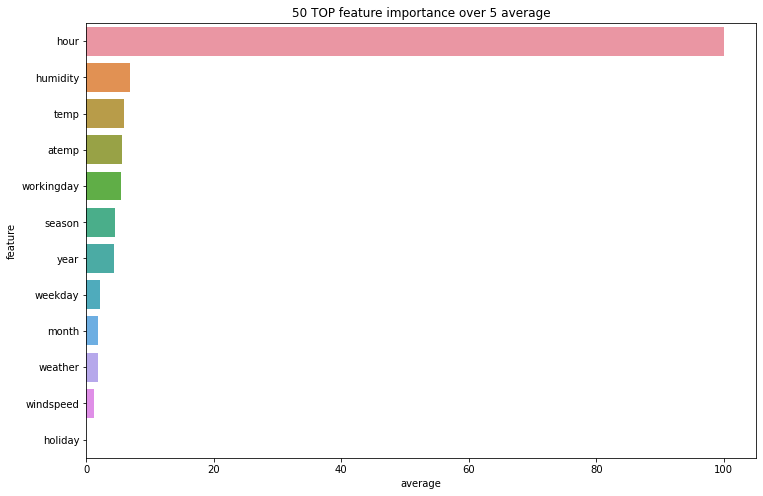

In [11]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = train.columns


for fold_, mod in tqdm(enumerate(model5)):
    feature_importances['fold_{}'.format(fold_ + 1)] = mod.feature_importance(importance_type='gain')

    
scaler = MinMaxScaler(feature_range=(0, 100))


feature_importances['average'] = scaler.fit_transform(X=pd.DataFrame(feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)))

fig = plt.figure(figsize=(12,8))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} average'.format(fold_+1))


Feature Selection

In [12]:
order_col_test = feature_importances.sort_values(by='average', ascending = True).feature.tolist()

train, test, numeric_col, categoric_col, strat, y = loader(path, gold = False)

order_col_test = ['month'] + [x for x in order_col_test if x!= 'month']


Mem. usage decreased from  2.87 Mb to  1.79 Mb (37.6% reduction)



Mem. usage decreased from  1.19 Mb to  0.75 Mb (37.5% reduction)



Mem. usage decreased from  0.61 Mb to  0.61 Mb (0.0% reduction)


In [13]:
for col in tqdm(order_col_test):
    
    temp = train.drop(col, axis = 1).copy()
    categoric_col_temp = [x for x in categoric_col if x != col]
    
    temp_score = cv_scorer(temp, categoric_col_temp)
    
    if temp_score < score:
        print(f'Dropping: {col}; Increment from: {score} to {temp_score}\n')
        train = temp
        categoric_col = categoric_col_temp
        score = temp_score
    else:
        print(f'Not Dropping: {col}; Initial score: {score} after drop: {temp_score}\n')


Not Dropping: month; Initial score: 0.2882683840277255 after drop: 0.2927847384886736

Not Dropping: holiday; Initial score: 0.2882683840277255 after drop: 0.2888173597946604

Dropping: windspeed; Increment from: 0.2882683840277255 to 0.2860971117159529

Not Dropping: weather; Initial score: 0.2860971117159529 after drop: 0.298481540351579

Not Dropping: weekday; Initial score: 0.2860971117159529 after drop: 0.3124816352347331

Not Dropping: year; Initial score: 0.2860971117159529 after drop: 0.348864945523915

Not Dropping: season; Initial score: 0.2860971117159529 after drop: 0.28729450121559275

Not Dropping: workingday; Initial score: 0.2860971117159529 after drop: 0.29029553351149007

Dropping: atemp; Increment from: 0.2860971117159529 to 0.28439103167320945

Not Dropping: temp; Initial score: 0.28439103167320945 after drop: 0.29476900800332956

Not Dropping: humidity; Initial score: 0.28439103167320945 after drop: 0.28864986806485277

Not Dropping: hour; Initial score: 0.28439103

In [14]:
test = test[train.columns]

In [15]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle = True, random_state = 0)

pred = np.zeros(train.shape[0])
pred_test = np.zeros(test.shape[0])

score = []

model5 =[]

gc.collect()
for fold_ , (trn_idx, val_idx) in tqdm(enumerate(folds.split(train, strat))):
        
        gc.collect()
        
        train_x, train_y = train.loc[trn_idx,:], y[trn_idx]
        valid_x, valid_y = train.loc[val_idx,:], y[val_idx]
        
        model = lgb.train(
            params,
            lgb.Dataset(train_x, label = train_y, categorical_feature = categoric_col),
            100000, valid_sets = lgb.Dataset(valid_x, label = valid_y, categorical_feature = categoric_col),
            categorical_feature = categoric_col,
            valid_names ='validation',
            verbose_eval = 500, early_stopping_rounds = 150
        )
    
        temp_y = model.predict(valid_x)
                
        pred[val_idx] = temp_y
        pred_test += model.predict(test)/n_fold

        score += [rmse(valid_y, temp_y)]
        
        print('\nFold: {}; RMLSE: {:.3f}\n'.format(fold_, rmse(valid_y, temp_y)))
        
        model5.append(model)
        

print('CV - RMSE : {}; STD: {}\n'.format(np.mean(score), np.std(score)))
pred_test = np.expm1(pred_test)

score = np.mean(score)


Training until validation scores don't improve for 150 rounds
[500]	validation's rmse: 0.296342
Early stopping, best iteration is:
[586]	validation's rmse: 0.295782

Fold: 0; RMLSE: 0.296

Training until validation scores don't improve for 150 rounds
[500]	validation's rmse: 0.286261
Early stopping, best iteration is:
[470]	validation's rmse: 0.285952

Fold: 1; RMLSE: 0.286

Training until validation scores don't improve for 150 rounds
[500]	validation's rmse: 0.277773
Early stopping, best iteration is:
[562]	validation's rmse: 0.277162

Fold: 2; RMLSE: 0.277

Training until validation scores don't improve for 150 rounds
[500]	validation's rmse: 0.292386
Early stopping, best iteration is:
[500]	validation's rmse: 0.292386

Fold: 3; RMLSE: 0.292

Training until validation scores don't improve for 150 rounds
[500]	validation's rmse: 0.271454
Early stopping, best iteration is:
[428]	validation's rmse: 0.270674

Fold: 4; RMLSE: 0.271


CV - RMSE : 0.28439103167320945; STD: 0.00934377453389

Text(0.5, 1.0, '50 TOP feature importance over 5 average')

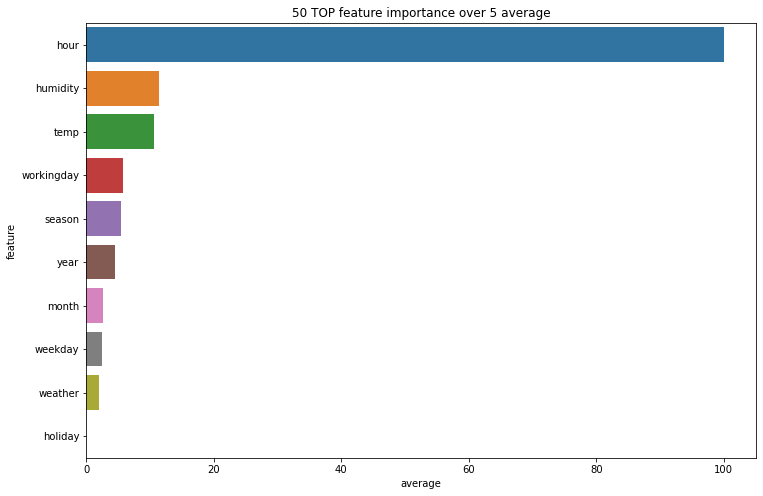

In [16]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = train.columns


for fold_, mod in tqdm(enumerate(model5)):
    feature_importances['fold_{}'.format(fold_ + 1)] = mod.feature_importance(importance_type='gain')

    
scaler = MinMaxScaler(feature_range=(0, 100))


feature_importances['average'] = scaler.fit_transform(X=pd.DataFrame(feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)))

fig = plt.figure(figsize=(12,8))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} average'.format(fold_+1))


In [17]:
submission = pd.read_csv(path + 'sampleSubmission.csv')
submission['count'] = pred_test

submission.to_csv('result.csv', index = False)